In [52]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
prasy46_credit_score_prediction_path = kagglehub.dataset_download('prasy46/credit-score-prediction')

print('Data source import complete.')


Data source import complete.


In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [54]:
!pip install shap

In [55]:
pip install optuna

In [56]:
import pandas as pd
import numpy as np
import shap
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
import pandas as pd

dataset = pd.read_csv('/root/.cache/kagglehub/datasets/prasy46/credit-score-prediction/versions/1/CreditScore_train.csv', sep=',', encoding='latin-1')
dataset.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x296,x297,x298,x299,x300,x301,x302,x303,x304,y
0,1084094,426.0,39.0,128.0,426.0,0,0,0,0,0,...,0,NaN,0,0,0,0,NaN,0,NaN,807
1,1287777,160.0,2.0,64.0,160.0,1,1,2,0,1,...,17318,0.8417,1,1,1,0,NaN,0,NaN,819
2,1483016,163.0,16.0,104.0,239.0,0,0,0,1,0,...,0,NaN,0,0,0,0,NaN,0,NaN,803
3,959054,NaN,NaN,NaN,102.0,0,0,0,0,0,...,0,NaN,1,1,1,0,NaN,0,NaN,530
4,1342113,3.0,2.0,2.0,62.0,0,2,2,0,0,...,17413,1.0180,1,1,1,0,NaN,0,NaN,485


In [58]:
#check the shape of data
dataset.shape

(80000, 305)

In [59]:
# Handling missing values (fill with median for simplicity)
dataset.fillna(dataset.median(), inplace=True)

# Separate features and target
X = dataset.drop(columns=['y'])  # Assuming 'y' is the target column
y = dataset['y']

In [60]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds, squared=False)

In [62]:
# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-02-08 22:37:36,216] A new study created in memory with name: no-name-8346a514-ac45-49fb-9314-9b06096e4a00
[I 2025-02-08 22:38:41,917] Trial 0 finished with value: 25.454037139135025 and parameters: {'num_leaves': 113, 'max_depth': 8, 'learning_rate': 0.06144574235433366, 'n_estimators': 855, 'min_child_samples': 43, 'subsample': 0.7356263570662216, 'colsample_bytree': 0.9888617554922547}. Best is trial 0 with value: 25.454037139135025.
[I 2025-02-08 22:39:21,724] Trial 1 finished with value: 25.504575428980274 and parameters: {'num_leaves': 125, 'max_depth': 12, 'learning_rate': 0.08480981740139039, 'n_estimators': 373, 'min_child_samples': 31, 'subsample': 0.7704759919990214, 'colsample_bytree': 0.5349454071174777}. Best is trial 0 with value: 25.454037139135025.
[I 2025-02-08 22:39:34,246] Trial 2 finished with value: 30.052464040799798 and parameters: {'num_leaves': 31, 'max_depth': 4, 'learning_rate': 0.02731248920736378, 'n_estimators': 335, 'min_child_samples': 56, 'subsa

In [63]:
# Train final model with best parameters
best_params = study.best_params
final_model = lgb.LGBMRegressor(**best_params)
final_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.7173195143826387,
              learning_rate=0.05658459331571086, max_depth=11,
              min_child_samples=31, n_estimators=990, num_leaves=124,
              subsample=0.7616359807095417)

In [64]:
# Predictions
y_pred = final_model.predict(X_test)

In [65]:
# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, R2 Score: {r2}')

MSE: 629.1353470506168, R2 Score: 0.9547928956260522


In [66]:
import matplotlib.pyplot as plt

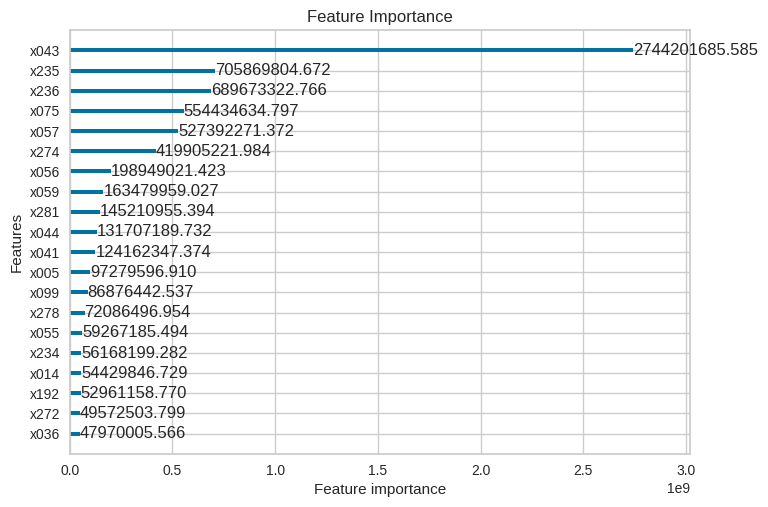

In [67]:
# Feature importance plot
lgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
plt.title("Feature Importance")
plt.show()

In [68]:
# SHAP Analysis
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test)

100%|===================| 15994/16000 [28:14<00:00]       

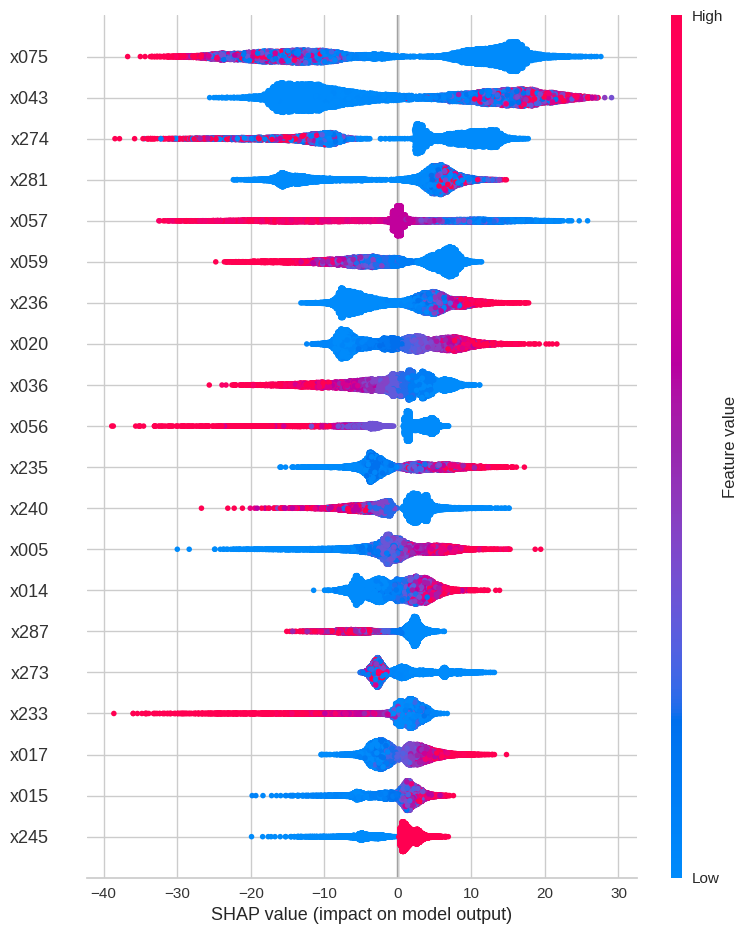

In [69]:
# Summary plot
shap.summary_plot(shap_values, X_test)

In [70]:
import joblib

In [71]:
# Save the trained model as a .pkl file
joblib.dump(final_model, 'lightgbm_model.pkl')
print("Model saved as lightgbm_model.pkl")

Model saved as lightgbm_model.pkl


In [74]:
test_dataset = pd.read_csv('/root/.cache/kagglehub/datasets/prasy46/credit-score-prediction/versions/1/CreditScore_test.csv', sep=',', encoding='latin-1')
test_dataset.shape

(20000, 305)

In [81]:
import joblib
import pandas as pd

# Load the trained model
loaded_model = joblib.load('lightgbm_model.pkl') # Load the model from the .pkl file

# Load the test dataset
test_dataset = pd.read_csv('/root/.cache/kagglehub/datasets/prasy46/credit-score-prediction/versions/1/CreditScore_test.csv', sep=',', encoding='latin-1')
test_dataset=test_dataset.drop(columns=['y'])
# Make predictions on the test dataset
test_predictions = loaded_model.predict(test_dataset) #Moved this line up

# Convert predictions to DataFrame and save
test_dataset['Predicted_y'] = test_predictions #Now this line should work

In [82]:
test_dataset.head(5)

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x296,x297,x298,x299,x300,x301,x302,x303,x304,Predicted_y
0,1566464,21.0,21.0,21.0,44.0,1,0,0,4,0,...,0,NaN,0,0,1,1,5.0,0,NaN,427.589404
1,925102,108.0,2.0,27.0,156.0,0,2,3,3,1,...,13090,0.593,1,1,1,0,1.0,0,NaN,727.180221
2,1273974,218.0,64.0,107.0,218.0,0,0,0,0,0,...,13689,1.014,1,1,1,0,1.0,13689,1.014,763.199228
3,1456723,NaN,NaN,NaN,146.0,1,0,0,1,1,...,0,NaN,1,1,1,0,NaN,0,NaN,479.594041
4,798267,0.0,0.0,0.0,230.0,1,2,4,0,2,...,0,NaN,1,1,1,0,NaN,0,NaN,563.546705


In [79]:
test_dataset = pd.read_csv('/root/.cache/kagglehub/datasets/prasy46/credit-score-prediction/versions/1/CreditScore_test.csv', sep=',', encoding='latin-1')
test_dataset.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x296,x297,x298,x299,x300,x301,x302,x303,x304,y
0,1566464,21.0,21.0,21.0,44.0,1,0,0,4,0,...,0,NaN,0,0,1,1,5.0,0,NaN,406
1,925102,108.0,2.0,27.0,156.0,0,2,3,3,1,...,13090,0.593,1,1,1,0,1.0,0,NaN,679
2,1273974,218.0,64.0,107.0,218.0,0,0,0,0,0,...,13689,1.014,1,1,1,0,1.0,13689,1.014,750
3,1456723,NaN,NaN,NaN,146.0,1,0,0,1,1,...,0,NaN,1,1,1,0,NaN,0,NaN,515
4,798267,0.0,0.0,0.0,230.0,1,2,4,0,2,...,0,NaN,1,1,1,0,NaN,0,NaN,589
